`fdapde-py` is a Python package that wraps the Physics-Informed Statistical Models available in the C++ library [fdaPDE](https://github.com/fdaPDE/fdaPDE-cpp). 

### Spatial Regression with Partial Differential Equation Regularization
Consider a bounded, regular, open domain $\Omega\subset \mathbb{R}^d$. Let $y_i, \text{ for }i = 1,\ldots,n,$ be $n$ observations of a quantity of interest at locations $\mathbf{p}_i \in \Omega$. Let $\mathbf{x}_i \in \mathbb{R}^q$ be the vector of covariates recorded at $\mathbf{p}_i$. Let $f:\Omega \rightarrow \mathbb{R}$ be a sufficiently smooth function that captures the spatial variation of the phenomenon under study.
Consider the following additive semiparametric model: 
$$y_i = \mathbf{x}^\top_i \mathbf{\beta} + f(\mathbf{p}_i) + \epsilon_i,$$
where $\epsilon_i, \ i=1, \ldots, n$ are $n$ independent errors with zero mean and finite variance. The SRPDE method estimates the two unknowns $\beta \in \mathbb{R}^q$ and $f$ by minimizing the following functional:
\begin{equation}
	(\hat{\mathbf{\beta}}, \hat{f}) := \text{argmin} \ \left\{\frac{1}{n}\sum_{i=1}^{n}(y_i-\mathbf{x}^\top_i \mathbf{\beta} - \mathit{f}(\mathbf{p}_{i}))^{2} + \lambda \left\lVert \mathcal{L}f - u \right\lVert_{L^2(\Omega)}^2 \right\}.
\end{equation}
The functional consists of a data-fitting term, based on classical least-squares errors, and a model-fitting term, formalized as a roughness penalty that penalizes deviations from a governing PDE. The positive smoothing parameter $\lambda$ balances data adaptation with the model-fitting criterion.

#### Solving a nonparametric SRPDE problem in Python
This example considers a nonparametric spatial regression problem over the unit square domain $\Omega$. Consider $f_{ex}(\mathbf{p}) = \sin(2\pi \ p_1) \sin(2 \pi \ p_2)$ as the true spatial field for this application which is the function we aim to estimate. The observations are generated by evaluating the true spatial field at $n$ locations uniformly scattered over $\Omega$, with Gaussian noise added. The noise variance is set to $5%$ of the range of the true function: 
$$y_i = f_{ex}(\mathbf{p}_i) + \epsilon_i.$$

The following code snippet wraps all the steps necessary to solve the problem.

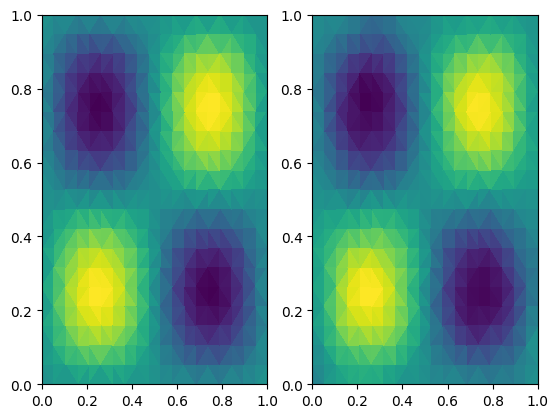

In [1]:
import fdapdepy as fdapde
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# data generation
nlocs = 500
p0 = np.random.uniform(0,1,nlocs)
p1 = np.random.uniform(0,1,nlocs)
f_ex = lambda p0, p1 : np.sin(2*np.pi*p0) * np.sin(2*np.pi*p1)
f_ = f_ex(p0,p1)
f_ =  f_.reshape((f_.shape[0],1))
obs = f_ + 0.05 * np.random.randn(nlocs,1)
data = pd.DataFrame(np.matrix([obs.reshape(-1), p0, p1]).transpose(), columns=["y", "p0", "p1"])
# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.domain(nodes, triangles, boundary)
# unknown spatial field
basis = fdapde.functional_basis(mesh, 1)
basis.size()
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.
# statistical model 
model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                     penalty=penalty)

gcv = fdapde.gcv(smooth_params = np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))
model.fit(calibration=gcv)
    
fig, ax = plt.subplots(1,2)
ax[0].tripcolor(nodes[:,0], nodes[:,1], f_ex(nodes[:,0], nodes[:,1]))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()


The following sections explain in more detail the previous code snippet.

##### Defining the domain
First, we create a `domain` object which takes three NumPy matrices as parameters

* `nodes`: a 2-column matrix containing the coordinates of the mesh nodes. 

* `elements`: a 3-column matrix where each row $i$ contains the indices of the mesh nodes that form the vertices of the $i$-th element.

* `boundary`: a 1-column matrix that identifies the nodes on the boundary of the domain. 


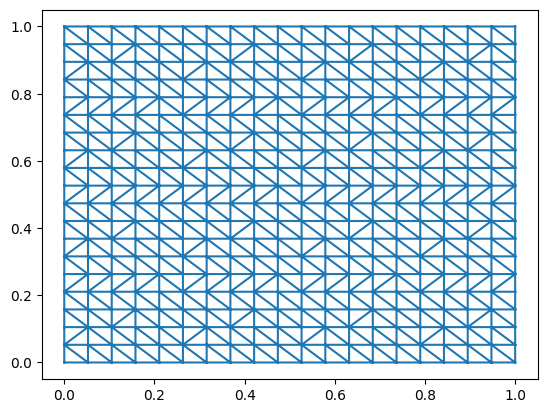

In [2]:
# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.domain(nodes, triangles, boundary)

triangulation = Triangulation(mesh.nodes()[:,0], mesh.nodes()[:,1], mesh.elements())
fig, ax = plt.subplots()
_ = ax.triplot(triangulation)

##### Defining the solution of the PDE and the differential operator
We begin by initializing a `basis` , passing in the previously constructed mesh and specifying the finite element order. Note that the package supports first- and second-order finite elements.
Next, we define a finite element (FE) `function`, which serves as the discrete estimator for $f_{ex}$, along with the differential operator in its strong formulation.

In [3]:
basis = fdapde.functional_basis(mesh, 1)
# discrete estimator
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  

##### Defining the penalty term
We define the penalty term as a `pde` object, which takes the differential operator in its strong formulation and the forcing term as arguments. By default, the forcing term is set to 0.
Note that $f_{ex}$ satisfies the following partial differential equation:
$$
\begin{cases}
-\Delta f = u  &in \ \Omega \\
      \quad u = 0  &on \ \partial \Omega
\end{cases}
$$

where $u(x,y) = 8\pi^2 \sin( 2\pi x)\sin(2\pi y)$ is the forcing term and $\partial \Omega$ is the boundary of $\Omega$ where we have prescribed homogeneous Dirichelet boundary condition.

It is important to note that, for this simulation study, we assume no prior information about the specific problem. As a result, we neither set the known forcing term for this example nor the Dirichlet boundary condition explicitly.

In [4]:
penalty = fdapde.pde(Lf) # forcing == 0, NO Dirichlet BC

##### Defining the SRPDE model
We define the SRPDE model by passing an R-like formula, a pandas `DataFrame`, and the previously instantiated penalty object as arguments. The model is then fitted using the fit method, which optionally takes a calibration parameter.

In [5]:
model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                     penalty=penalty)

gcv = fdapde.gcv(smooth_params= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))
model.fit(calibration=gcv)

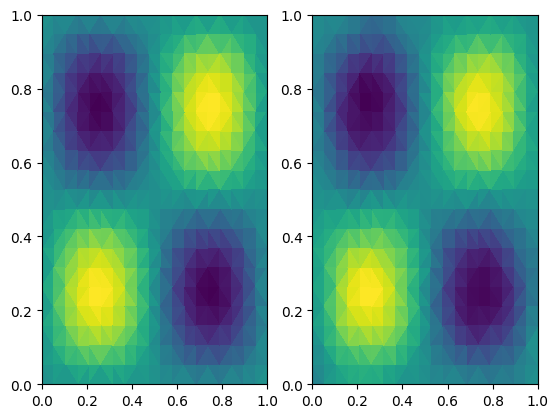

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].tripcolor(nodes[:,0], nodes[:,1], f_ex(nodes[:,0], nodes[:,1]))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()

##### Numerical consistency of the SRPDE

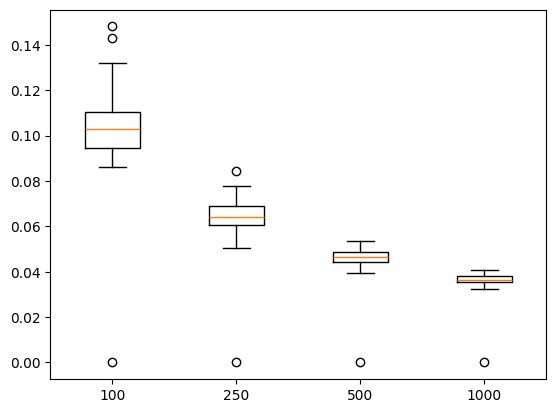

In [7]:
nlocs = [100, 250, 500, 1000]
nsim = 50
errors = np.zeros((nsim,len(nlocs)))

# true spatial field
f_ex = lambda p0, p1 : np.sin(2*np.pi*p0) * np.sin(2*np.pi*p1)

# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.domain(nodes, triangles, boundary)
# FE basis
basis = fdapde.functional_basis(mesh, 1)
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.
gcv = fdapde.gcv(smooth_params= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))

def rmse(x,y):
    return np.sqrt( np.mean( (x-y)*(x-y) ))

for i in range(0,len(nlocs)):
    for j in range(0,nsim-1):
        p0 = np.random.uniform(0,1,nlocs[i])
        p1 = np.random.uniform(0,1,nlocs[i])
        f_ = f_ex(p0,p1)
        f_ =  f_.reshape((f_.shape[0],1))
        obs = f_ + 0.05 * np.random.randn(nlocs[i],1)
        data = pd.DataFrame(np.matrix([obs.reshape(-1), p0, p1]).transpose(), columns=["y", "p0", "p1"])
        model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                             penalty=penalty)
        model.fit(calibration=gcv)
        errors[j,i] = rmse( model.f(), f_ex(nodes[:,0], nodes[:,1]))

fig, ax = plt.subplots()
_ = ax.boxplot(errors, tick_labels=nlocs)